In [1]:
%matplotlib notebook

In [2]:
import matplotlib.pyplot as plt
import torch
import sympy

from constraint_prog.newton_raphson import newton_raphson
from constraint_prog.sympy_func import SympyFunc

In [3]:
inner_hull_radius = sympy.Symbol("inner_hull_radius")  # m
hull_thickness = sympy.Symbol("hull_thickness")  # m

outer_hull_radius = inner_hull_radius + hull_thickness
hull_thickness = outer_hull_radius - inner_hull_radius  # m
thin_hoop_condition = hull_thickness < 0.1 * inner_hull_radius  # bool
thin_hoop_coefficient = inner_hull_radius / hull_thickness
thick_hoop_coefficient = (outer_hull_radius ** 2 + inner_hull_radius ** 2) / \
    (outer_hull_radius ** 2 - inner_hull_radius ** 2)
hoop_coefficient = sympy.Piecewise(
    (thin_hoop_coefficient, thin_hoop_condition),
    (thick_hoop_coefficient, True))

In [4]:
func = SympyFunc([hoop_coefficient])

xpos = torch.linspace(0.1, 10.0, 50)
ypos = torch.linspace(0.1, 1.0, 50)
input_data = torch.stack(torch.meshgrid(xpos, ypos), dim=-1)
output_data = func(input_data)
print(func.input_names)
print(input_data.size(), output_data.size())

['inner_hull_radius', 'hull_thickness']
torch.Size([50, 50, 2]) torch.Size([50, 50, 1])


<IPython.core.display.Javascript object>


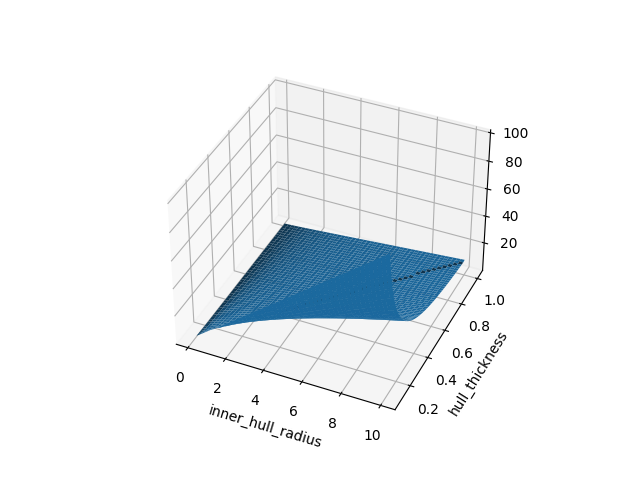

In [5]:
fig, ax1 = plt.subplots(subplot_kw={"projection": "3d"})
ax1.plot_surface(
    input_data[:, :, 0].numpy(), 
    input_data[:, :, 1].numpy(), 
    output_data[:, :, 0].numpy())
ax1.set_xlabel(func.input_names[0])
ax1.set_ylabel(func.input_names[1])
plt.show()

In [6]:
hoop_coefficient_var = sympy.Symbol("hoop_coefficient_var")
func2 = SympyFunc([hoop_coefficient_var - hoop_coefficient])
print(func2.input_names, func2.input_size, func2.output_size)

input_data2 = torch.cat((torch.zeros(input_data.shape[:-1]).unsqueeze(dim=-1), input_data), dim=-1)
print(input_data2.shape)
input_data2 = newton_raphson(func2, input_data2, num_iter=1, epsilon=0.1)


['hoop_coefficient_var', 'inner_hull_radius', 'hull_thickness'] 3 1
torch.Size([50, 50, 3])


/home/mmaroti/.local/lib/python3.6/site-packages/torch/autograd/__init__.py:204: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  inputs, allow_unused)


<IPython.core.display.Javascript object>


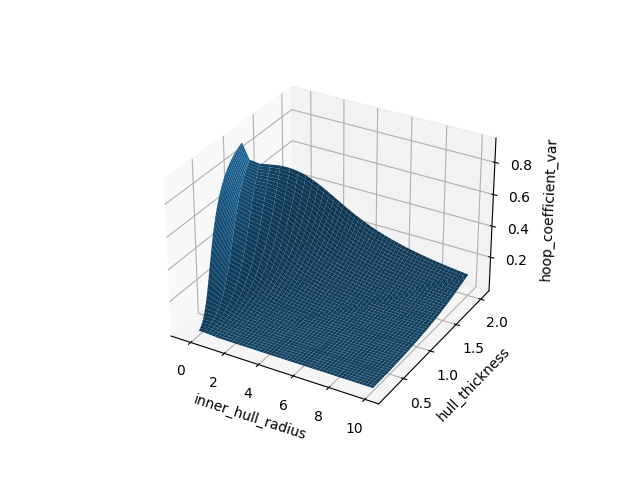

In [10]:
fig, ax1 = plt.subplots(subplot_kw={"projection": "3d"})
ax1.plot_surface(
    input_data2[:, :, 1].numpy(), 
    input_data2[:, :, 2].numpy(), 
    input_data2[:, :, 0].numpy())
ax1.set_xlabel(func2.input_names[1])
ax1.set_ylabel(func2.input_names[2])
ax1.set_zlabel(func2.input_names[0])
plt.show()